3.048


(1.0, 4.0)

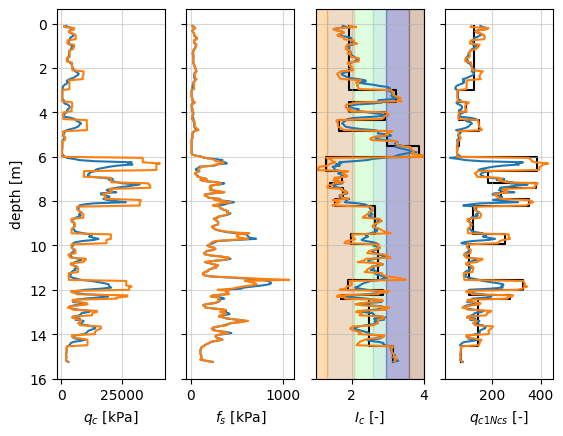

In [1]:
import numpy as np
import json
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import smt

def interleave(v1, v2):
    vout = np.empty(2 * len(v1), dtype=float)
    vout[0::2] = v1
    vout[1::2] = v2
    return vout 
    
url = 'https://uclageo.com/coastal_database/conePenetrationTests'
headers = {'User-Agent':'XY', 'Accept':'application/json'}
r = requests.get(url,headers=headers)
cpt_df = pd.read_json(io.StringIO(r.text))
data = cpt_df['data'].values
dGWT = cpt_df['groundwater_measured'].values[0]
print(dGWT)
cpt_dict = json.loads(cpt_df.data.values[0])
depth = np.asarray(cpt_dict['depth'])
qc = np.asarray(cpt_dict['qc'])*1000
fs = np.asarray(cpt_dict['fs'])*1000
sigmav = 19 * depth
u = (depth - dGWT) * 9.81
u[u<0] = 0
sigmavp = sigmav - u
qt_inv, fs_inv, Ic_inv = smt.cpt_inverse_filter(qc, depth, fs=fs, sigmav=sigmav, sigmavp=sigmavp)
Ic, Qtn, Fr = smt.get_Ic_Qtn_Fr(qc, fs, sigmav, sigmavp)
Ic_inv, Qtn_inv, Fr_inv = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, sigmav, sigmavp)
FC = smt.get_FC_from_Ic(Ic_inv, 0.0)
qc1N, qc1Ncs = smt.get_qc1N_qc1Ncs(qc, fs, sigmav, sigmavp, FC)
qc1N_inv, qc1Ncs_inv = smt.get_qc1N_qc1Ncs(qt_inv, fs_inv, sigmav, sigmavp, FC)
ztop, zbot, qc1Ncs_lay, Ic_lay = smt.cpt_layering(qc1Ncs_inv, Ic_inv, depth, dGWT=dGWT, Nmin=1, Nmax=None)
fig, ax = plt.subplots(ncols=4, sharey='row')

ax[0].plot(qc, depth)
ax[0].plot(qt_inv, depth)
ax[1].plot(fs, depth)
ax[1].plot(fs_inv, depth)
ax[2].plot(Ic, depth)
ax[2].plot(Ic_inv, depth)
ax[3].plot(qc1Ncs, depth)
ax[3].plot(qc1Ncs_inv, depth)
ax[2].axvspan(1,1.31,alpha=0.3,color='darkorange')
ax[2].axvspan(1.31,2.05,alpha=0.3,color='peru')
ax[2].axvspan(2.05,2.6,alpha=0.3,color='palegreen')
ax[2].axvspan(2.6,2.95,alpha=0.3,color='mediumaquamarine')
ax[2].axvspan(2.95,3.6,alpha=0.3,color='navy')
ax[2].axvspan(3.6,4.0,alpha=0.3,color='saddlebrown')
ax[0].set_ylabel('depth [m]')
ax[0].set_xlabel(r'$q_c$ [kPa]')
ax[1].set_xlabel(r'$f_s$ [kPa]')
ax[2].set_xlabel(r'$I_c$ [-]')
ax[3].set_xlabel(r'$q_{c1Ncs}$ [-]')
for a in ax:
    a.grid(True, alpha=0.5)
ax[2].plot(interleave(Ic_lay,Ic_lay), interleave(ztop,zbot), color='black', zorder=1)
ax[3].plot(interleave(qc1Ncs_lay,qc1Ncs_lay), interleave(ztop,zbot), color='black', zorder=1)
ax[0].invert_yaxis()
ax[2].set_xlim(1,4)

In [3]:
output_df = pd.DataFrame()
output_df['depth'] = depth
output_df['qc'] = qc
output_df['fs'] = fs
output_df.to_csv('example_cpt.csv')

Text(0.5, 0.98, '$P[M_P]$ = 40.3 %')

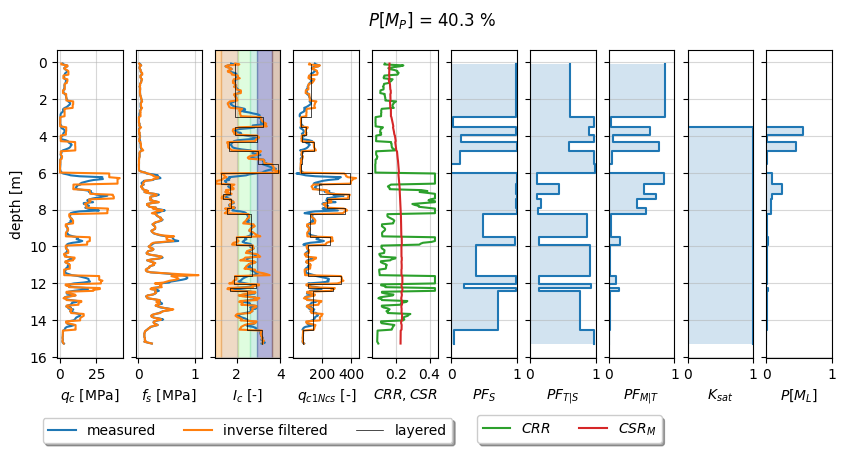

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import smt

# Ready example CPT file and extract data into Numpy arrays
df = pd.read_csv('example_cpt.csv')
depth = df['depth'].values
qc = df['qc'].values
fs = df['fs'].values

# Define earthquake loading conditions
amax = 0.3
m = 7.0

# Compute vertical total stress and vertical effective stess. For simplicity, use constant unit weight of 19 kN/m3.
gamma = 19
dGWT = 3.0
sigmav = gamma * depth
u = 9.81 * (depth - dGWT)
u[u<0] = 0.0
sigmavp = sigmav - u

# Apply inverse filter and layering algorithm to CPT data
qt_inv, fs_inv, Ic_inv = smt.cpt_inverse_filter(qc, depth, fs=fs, sigmav=sigmav, sigmavp=sigmavp, low_pass=True, smooth=True, remove_interface=True)
Ic, Qtn, Fr = smt.get_Ic_Qtn_Fr(qc, fs, sigmav, sigmavp)
Ic_inv, Qtn_inv, Fr_inv = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, sigmav, sigmavp)
FC = smt.get_FC_from_Ic(Ic_inv, 0.0)
qc1N, qc1Ncs = smt.get_qc1N_qc1Ncs(qc, fs, sigmav, sigmavp, FC)
qc1N_inv, qc1Ncs_inv = smt.get_qc1N_qc1Ncs(qt_inv, fs_inv, sigmav, sigmavp, FC)
ztop, zbot, qc1Ncs_lay, Ic_lay = smt.cpt_layering(qc1Ncs_inv, Ic_inv, depth, dGWT=dGWT, Nmin=1, Nmax=None)
sigmav_lay = np.interp(0.5 * (ztop + zbot), depth, sigmav)
sigmavp_lay = np.interp(0.5 * (ztop + zbot), depth, sigmavp)

# Use helper functions to compute necessary quantities. Use layered data.
# CRR and CSRM for plotting purposes
crr_hat = smt.get_crr_hat(qc1Ncs_inv)
crr = smt.inv_box_cox(crr_hat, lambda_CSR)
csrm = smt.get_csrm(amax, m, sigmav, sigmavp, depth, qc1Ncs_inv)

crr_hat_lay = smt.get_crr_hat(qc1Ncs_lay)
lambda_CSR = -0.361
lambda_DR = 1.226
crr_lay = smt.inv_box_cox(crr_hat_lay, lambda_CSR)
csrm_lay = smt.get_csrm(amax, m, sigmav_lay, sigmavp_lay, 0.5 * (ztop + zbot), qc1Ncs_lay)
csrm_hat_lay = smt.box_cox(csrm_lay, lambda_CSR)
Ksat_lay = np.zeros(len(ztop))
Ksat_lay[ztop>dGWT] = 1.0
t = zbot - ztop

# Use primary SMT functions to compute probability of profile manifestation
pfs = smt.get_pfs(Ic_lay)
pfts = smt.get_pfts(csrm_hat_lay, crr_hat_lay)
pfmt = smt.get_pfmt(ztop, Ic_lay)
pml = pfs * pfts * pfmt * Ksat_lay
pmp = smt.get_pmp(pfmt, pfts, pfs, Ksat, t)

fig, ax = plt.subplots(ncols=10, sharey='row', figsize=(10,4))

ax[0].plot(qc/1000, depth)
ax[0].plot(qt_inv/1000, depth)
ax[1].plot(fs/1000, depth)
ax[1].plot(fs_inv/1000, depth)
ax[2].plot(Ic, depth, label='measured')
ax[2].plot(Ic_inv, depth, label='inverse filtered')
ax[3].plot(qc1Ncs, depth)
ax[3].plot(qc1Ncs_inv, depth)
ax[4].plot(crr, depth, label=r'$CRR$', c='C2')
ax[4].plot(csrm, depth, label=r'$CSR_M$', c='C3')
ax[5].plot(interleave(pfs, pfs), interleave(ztop,zbot))
ax[5].fill_betweenx(interleave(ztop, zbot), np.zeros(2*len(ztop)), interleave(pfs, pfs), facecolor='C0', alpha=0.2)
ax[6].plot(interleave(pfts, pfts), interleave(ztop,zbot))
ax[6].fill_betweenx(interleave(ztop, zbot), np.zeros(2*len(ztop)), interleave(pfts, pfts), facecolor='C0', alpha=0.2)
ax[7].plot(interleave(pfmt, pfmt), interleave(ztop,zbot))
ax[7].fill_betweenx(interleave(ztop, zbot), np.zeros(2*len(ztop)), interleave(pfmt, pfmt), facecolor='C0', alpha=0.2)
ax[8].plot(interleave(Ksat_lay, Ksat_lay), interleave(ztop,zbot))
ax[8].fill_betweenx(interleave(ztop, zbot), np.zeros(2*len(ztop)), interleave(Ksat_lay, Ksat_lay), facecolor='C0', alpha=0.2)
ax[9].plot(interleave(pml, pml), interleave(ztop,zbot))
ax[9].fill_betweenx(interleave(ztop, zbot), np.zeros(2*len(ztop)), interleave(pml, pml), facecolor='C0', alpha=0.2)
ax[2].axvspan(1,1.31,alpha=0.3,color='darkorange')
ax[2].axvspan(1.31,2.05,alpha=0.3,color='peru')
ax[2].axvspan(2.05,2.6,alpha=0.3,color='palegreen')
ax[2].axvspan(2.6,2.95,alpha=0.3,color='mediumaquamarine')
ax[2].axvspan(2.95,3.6,alpha=0.3,color='navy')
ax[2].axvspan(3.6,4.0,alpha=0.3,color='saddlebrown')
ax[0].set_ylabel('depth [m]')
ax[0].set_xlabel(r'$q_c$ [MPa]')
ax[1].set_xlabel(r'$f_s$ [MPa]')
ax[2].set_xlabel(r'$I_c$ [-]')
ax[3].set_xlabel(r'$q_{c1Ncs}$ [-]')
ax[4].set_xlabel(r'$CRR, CSR$')
ax[5].set_xlabel(r'$PF_S$')
ax[6].set_xlabel(r'$PF_{T|S}$')
ax[7].set_xlabel(r'$PF_{M|T}$')
ax[8].set_xlabel(r'$K_{sat}$')
ax[9].set_xlabel(r'$P[M_L]$')
for a in ax:
    a.grid(True, alpha=0.5)
ax[2].plot(interleave(Ic_lay,Ic_lay), interleave(ztop,zbot), color='black', zorder=2, linewidth=0.5, label='layered')
ax[3].plot(interleave(qc1Ncs_lay,qc1Ncs_lay), interleave(ztop,zbot), color='black', zorder=2, linewidth=0.5)
ax[0].invert_yaxis()
ax[2].set_xlim(1.0,4.0)
ax[5].set_xlim(0.0,1.0)
ax[6].set_xlim(0.0,1.0)
ax[7].set_xlim(0.0,1.0)
ax[8].set_xlim(0.0,1.0)
ax[9].set_xlim(0.0,1.0)
ax[2].legend(loc='lower center', bbox_to_anchor=(0.5,-0.3), ncol=3, fancybox=True, shadow=True)
ax[4].legend(loc='lower center', bbox_to_anchor=(3.0, -0.3), ncol=2, fancybox=True, shadow=True)
fig.suptitle(r'$P[M_P]$ = ' + str(np.round(pmp*100, 1)) + ' %')

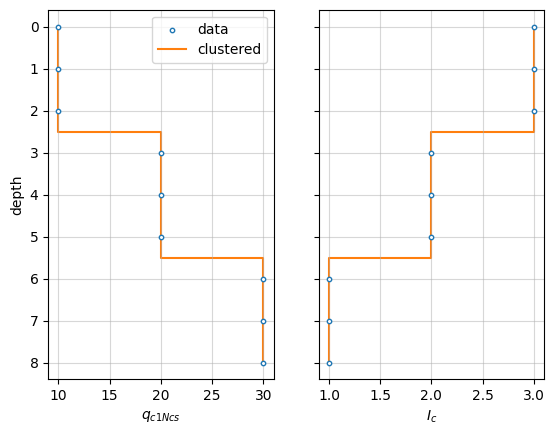

In [1]:
import numpy as np
import smt
import matplotlib.pyplot as plt

qc1Ncs = np.asarray([10, 10, 10, 20, 20, 20, 30, 30, 30], dtype=float)
Ic = np.asarray([3, 3, 3, 2, 2, 2, 1, 1, 1], dtype=float)
depth = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=float)
dGWT = 1.0
ztop, zbot, qc1Ncs_lay, Ic_lay = smt.cpt_layering(qc1Ncs, Ic, depth, dGWT=dGWT, Nmin=1, Nmax=None)

def interleave(v1, v2):
    vout = np.empty(2 * len(v1), dtype=float)
    vout[0::2] = v1
    vout[1::2] = v2
    return vout 

fig, ax = plt.subplots(ncols=2, sharey='row')
ax[0].scatter(qc1Ncs, depth, facecolor='white', edgecolor='C0', s=10, zorder=2, label='data')
ax[1].scatter(Ic, depth, facecolor='white', edgecolor='C0', s=10, zorder=2)
ax[0].plot(interleave(qc1Ncs_lay, qc1Ncs_lay), interleave(ztop, zbot), c='C1', zorder=1, label='clustered')
ax[1].plot(interleave(Ic_lay, Ic_lay), interleave(ztop, zbot), c='C1', zorder=1)

for a in ax:
    a.grid(True, alpha=0.5)

ax[0].set_ylabel('depth')
ax[0].set_xlabel(r'$q_{c1Ncs}$')
ax[1].set_xlabel(r'$I_c$')
ax[0].invert_yaxis()
ax[0].legend()